Epoch 1/100


2024-11-14 15:59:31.431048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-14 15:59:31.431072: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-14 15:59:31.431080: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-14 15:59:31.431095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 15:59:31.431105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/sugang/Desktop/projects/2024coin/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0115 - val_loss: 6.9458e-04
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.7012e-04 - val_loss: 0.0017
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.0720e-04 - val_loss: 0.0011
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1281e-04 - val_loss: 4.8800e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8345e-04 - val_loss: 5.2416e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.4461e-04 - val_loss: 0.0013
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.6807e-04 - val_loss: 5.1430e-04
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
RMSE: 2160128.865898849
R² Score: 0.99370603367036


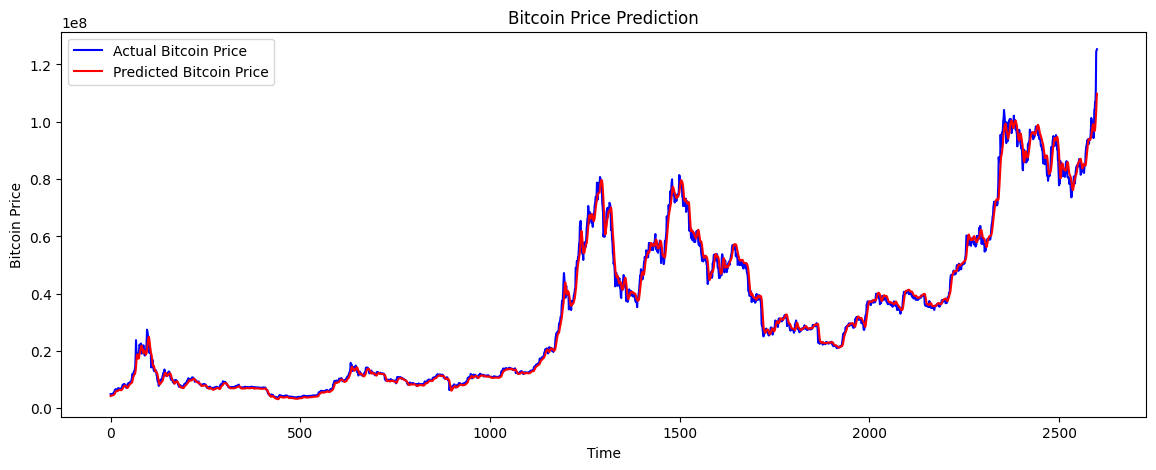

CSV saved as 'full_data_with_predictions.csv'


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import os
# Change the working directory to strategy_lab
os.chdir("/Users/sugang/Desktop/projects/2024coin/strategy_lab")
import matplotlib.pyplot as plt
from handle_candle import resample_df
from datetime import datetime



# Load the full original data
df_full = pd.read_csv('temp.csv')

# Preprocess the full data for time resampling
execution_time = datetime.strptime("00:00", "%H:%M")
df_full = resample_df(df_full, execution_time=execution_time)

# Calculate the Daily Return and remove unwanted columns
df_full['Daily Return'] = df_full['close'].pct_change()
df_full.dropna(inplace=True)  # Remove NaN values caused by percentage change

# Save the full DataFrame before dropping columns
df_preprocessed = df_full.copy()

# Use only the required features for model training
df_full.drop(columns=["time_utc"], inplace=True)
features = df_full[['open', 'high', 'low', 'close', 'volume_krw', 'volume_market', 'Daily Return']].values

# Normalize features and close prices
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df_full[['close']].values)

# Prepare the data for LSTM
sequence_length = 5
x, y = [], []

for i in range(sequence_length, len(scaled_features)):
    x.append(scaled_features[i-sequence_length:i])
    y.append(scaled_close[i, 0])  # Predicting the scaled 'close' price

x, y = np.array(x), np.array(y)

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(units=100, activation='tanh', return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(x, y, epochs=100, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

# Make predictions on the entire dataset
predictions = model.predict(x)
predictions = close_scaler.inverse_transform(predictions)

# Calculate RMSE and R² score on the entire dataset
y_original = close_scaler.inverse_transform(y.reshape(-1, 1))
rmse = np.sqrt(mean_squared_error(y_original, predictions))
r2 = r2_score(y_original, predictions)
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(y_original, color='blue', label='Actual Bitcoin Price')
plt.plot(predictions, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# Append predictions to the full DataFrame
df_results = df_preprocessed.iloc[sequence_length:].copy()  # Skip the initial sequence length
df_results['predict_close'] = predictions

# Save the updated DataFrame as a CSV file
df_results.to_csv('1/full_data_with_predictions.csv', index=False)

# Print the path to the saved CSV file
print("CSV saved as 'full_data_with_predictions.csv'")
